In [262]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nb

import torch
import torch.nn as nn
from torchdiffeq import odeint

from tqdm.notebook import tqdm

In [263]:
cifti_dir = "/home/cole/_research/data/ML_analysis_data/fMRI_ciftis/rfMRI_REST1_7T_PA"
hd5_path = "/home/cole/_research/data/ML_analysis_data/HCP_7T_rfMRI_Schaefer400.hdf5"

In [264]:
with h5py.File(hd5_path, "r") as file:
    states = file["tfMRI"]["100610"][:]
# file = h5py.File(hd5_path, "r")

### Diffrax Examples

In [265]:
import jax.numpy as jnp
import jax
from diffrax import diffeqsolve, ODETerm, Dopri5


def f(t, y, args):
    return -y

term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2., 3.])
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)

In [266]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

t0 = 0
tf = 30

vector_field = lambda t, y, args: - jnp.sin(t) / (y + 1)

term = ODETerm(vector_field)
solver = Dopri5()
saveat = SaveAt(ts=jnp.linspace(0, tf, int(tf * 10)))
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
sol = diffeqsolve(term, solver, t0=0, t1=tf, dt0=0.1, y0=1, saveat=saveat,
                  stepsize_controller=stepsize_controller)

# print(sol.ts)  # DeviceArray([0.   , 1.   , 2.   , 3.    ])
# print(sol.ys)  # DeviceArray([1.   , 0.368, 0.135, 0.0498])


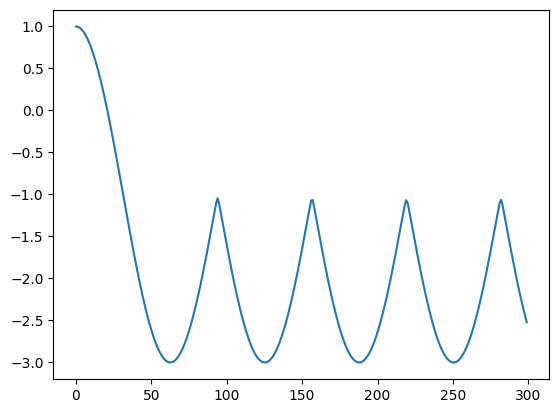

In [267]:
plt.plot(sol.ys)

In [113]:
import jax.random as jr
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

t0, t1 = 1, 3
drift = lambda t, y, args: -y
diffusion = lambda t, y, args: 0.1 * t
brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jr.PRNGKey(0))
terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=1.0, saveat=saveat)
print(sol.evaluate(1.1))  # DeviceArray(0.89436394)


0.96505475


In [114]:
from diffrax import AbstractPath, ControlTerm, diffeqsolve, Dopri5


class QuadraticPath(AbstractPath):
    @property
    def t0(self):
        return 0

    @property
    def t1(self):
        return 3

    def evaluate(self, t0, t1=None, left=True):
        del left
        if t1 is not None:
            return self.evaluate(t1) - self.evaluate(t0)
        return t0 ** 2


vector_field = lambda t, y, args: -y
control = QuadraticPath()
term = ControlTerm(vector_field, control).to_ode()
solver = Dopri5()

saveat = SaveAt(ts=jnp.linspace(0, 3, 20))
sol = diffeqsolve(term, solver, t0=0, t1=3, dt0=0.05, y0=1, saveat=saveat)

print(sol.ts)  # DeviceArray([3.])
print(sol.ys)  # DeviceArray([0.00012341])


[0.         0.15789473 0.31578946 0.4736842  0.6315789  0.78947365
 0.9473684  1.1052631  1.2631578  1.4210526  1.5789473  1.736842
 1.8947368  2.0526314  2.2105262  2.368421   2.5263157  2.6842103
 2.8421052  3.        ]
[1.0000000e+00 9.7537744e-01 9.0508813e-01 7.9901415e-01 6.7106283e-01
 5.3618938e-01 4.0758434e-01 2.9475626e-01 2.0279337e-01 1.3273636e-01
 8.2655482e-02 4.8966452e-02 2.7597586e-02 1.4797523e-02 7.5483504e-03
 3.6631988e-03 1.6912790e-03 7.4287324e-04 3.1042763e-04 1.2341011e-04]


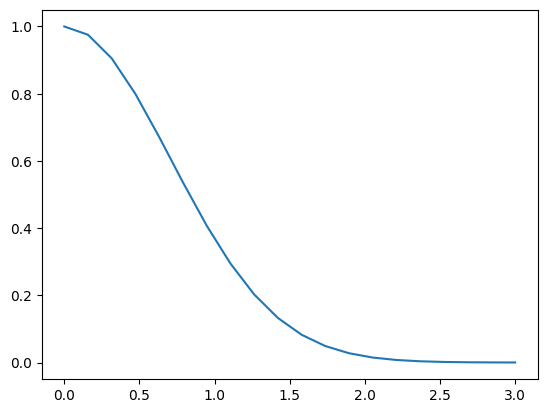

In [115]:
plt.plot(sol.ts, sol.ys)

In [116]:
import jax.numpy as jnp
from diffrax import ODETerm, Tsit5

vector_field = lambda t, y, args: -y
term = ODETerm(vector_field)
solver = Tsit5()

t0 = 0
dt0 = 0.05
t1 = 1
y0 = jnp.array(1.0)
args = None

tprev = t0
tnext = t0 + dt0
y = y0
state = solver.init(term, tprev, tnext, y0, args)

while tprev < t1:
    y, _, _, state, _ = solver.step(term, tprev, tnext, y, args, state, made_jump=False)
    print(f"At time {tnext} obtained value {y}")
    tprev = tnext
    tnext = min(tprev + dt0, t1)


At time 0.05 obtained value 0.9512293934822083
At time 0.1 obtained value 0.9048373699188232
At time 0.15000000000000002 obtained value 0.8607079386711121
At time 0.2 obtained value 0.8187307119369507
At time 0.25 obtained value 0.7788007259368896
At time 0.3 obtained value 0.7408181428909302
At time 0.35 obtained value 0.7046880125999451
At time 0.39999999999999997 obtained value 0.6703199744224548
At time 0.44999999999999996 obtained value 0.6376280784606934
At time 0.49999999999999994 obtained value 0.6065305471420288
At time 0.5499999999999999 obtained value 0.5769497156143188
At time 0.6 obtained value 0.5488115549087524
At time 0.65 obtained value 0.5220456719398499
At time 0.7000000000000001 obtained value 0.4965851902961731
At time 0.7500000000000001 obtained value 0.47236645221710205
At time 0.8000000000000002 obtained value 0.44932886958122253
At time 0.8500000000000002 obtained value 0.42741483449935913
At time 0.9000000000000002 obtained value 0.40656957030296326
At time 0.

# fMRI States

In [203]:
jstates = jnp.array(states)[:, :100]

In [253]:
c = 1

A_t = jax.random.normal(key, (jstates.shape[1], jstates.shape[1]))

A_t = jnp.abs(A_t) + jnp.abs(A_t.T)
# A_t = A_t / jnp.max(A_t)
A_t = A_t.at[jnp.diag_indices_from(A_t)].set(10)
w, v = jnp.linalg.eigh(A_t)

A_t = A_t / (c + w.max())
A_t -= jnp.eye(A_t.shape[-1])

In [258]:
import seaborn as sns

In [260]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

t0 = 0
tf = 10

y0 = jstates[0]


LTI_system = lambda t, y, args: A_t @ y

term = ODETerm(LTI_system)
solver = Dopri5()
saveat = SaveAt(ts=jnp.linspace(0, tf, int(tf * 10)))
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
sol = diffeqsolve(term, solver, t0=0, t1=tf, dt0=0.1, y0=y0, saveat=saveat,
                  stepsize_controller=stepsize_controller)

# print(sol.ts)  # DeviceArray([0.   , 1.   , 2.   , 3.    ])
# print(sol.ys)  # DeviceArray([1.   , 0.368, 0.135, 0.0498])


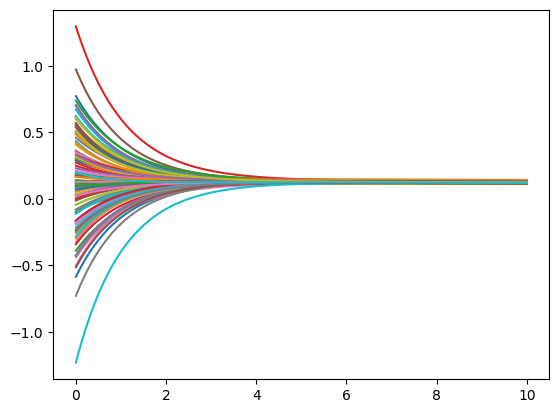

In [261]:
plt.plot(sol.ts, sol.ys);

## A optimization

In [739]:
import jax
import jax.numpy as jnp
from diffrax import ODETerm, Euler
from jax import grad
import optax

In [786]:
# Define the dynamic system
# @jax.jit
def NCT_equation(t, X, args):
    A = args
    return A @ X

jstates = jnp.array(states)[:, :]
X0 = jstates[0]
Xf = jstates[3]

X_middles = jstates[1:20]

t0 = 0.0
tf = len(X_middles)

ts = jnp.linspace(0, tf, int(tf * 10) + 1)
middle_ts_indices = jnp.arange(1, tf + 1) * 10


# Initial guess for A
A_t = jax.random.normal(key, (jstates.shape[1], jstates.shape[1]))
A_t = jnp.abs(A_t) + jnp.abs(A_t.T)
A_t = A_t / jnp.max(A_t)
A_t = A_t.at[jnp.diag_indices_from(A_t)].set(10)
w, v = jnp.linalg.eigh(A_t)

A_t = A_t / (c + w.max())
A_t -= jnp.eye(A_t.shape[-1])

A_init = A_t

# Define the ODE solving function
# @jax.jit
def solve_ode(A):
    term = ODETerm(NCT_equation)
    solver = Dopri5()
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)    
    saveat = SaveAt(ts=jnp.linspace(0, tf, int(tf * 10) + 1))
    solution = diffeqsolve(
        term, solver, t0=t0, t1=tf, dt0=0.1, y0=X0, args=A,
        stepsize_controller=stepsize_controller,
        saveat=saveat
    )
    return solution.ys[middle_ts_indices], solution  # Final value

# Define loss function (mean squared error between final state and target)
# @jax.jit
def loss_fn(A):
    X_middles_pred, _ = solve_ode(A)
    reg = jnp.sum(A ** 2)
    return 100 * jnp.mean((X_middles_pred - X_middles) ** 2) #+ 1e-3 * reg

In [787]:
NCT_equation(t0, X0, A_init);
solve_ode(A_init);
loss_fn(A_init);

In [788]:
%%timeit
_ = loss_fn(A_init)

47.1 ms ± 417 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [792]:
# Set up optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(A_init)

# Optimization step function
@jax.jit
def step(A, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(A)
    updates, opt_state = optimizer.update(grads, opt_state)
    A = optax.apply_updates(A, updates)
    return A, opt_state, loss

In [793]:
step(A_init, opt_state);

In [794]:
%%timeit
step(A_init, opt_state);

121 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Run optimization
A = A_init
# A = A_opt
# assert False
A_sets = []
previous_losses = [np.inf]

stop_tol = 1e-8
for i in tqdm(range(1000)):
    A, opt_state, loss = step(A, opt_state)

    L_delta = np.abs(np.mean(previous_losses) - loss)
    if (L_delta) <= stop_tol:
        print(L_delta, loss)
        print("Loss change < Stop tolerance")
        break

    previous_losses.append(loss)
    previous_losses = previous_losses[-10:]
    if i % 50 == 0:
        print(f"Step {i}, Loss: {loss}, ∂L: {L_delta}, A mean: {np.mean(A):.4f}, A sd: {np.std(A):.4f}")

A_opt = A

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0, Loss: 15.743440628051758, ∂L: inf, A mean: -0.0048, A sd: 0.0457
Step 50, Loss: 14.925783157348633, ∂L: 0.48038578033447266, A mean: -0.0078, A sd: 0.0828
Step 100, Loss: 16.014480590820312, ∂L: 0.07668685913085938, A mean: -0.0077, A sd: 0.0868
Step 150, Loss: 16.033815383911133, ∂L: 0.09253120422363281, A mean: -0.0075, A sd: 0.0897
Step 200, Loss: 15.644899368286133, ∂L: 0.1385507583618164, A mean: -0.0073, A sd: 0.0907
Step 250, Loss: 15.942131042480469, ∂L: 0.10206413269042969, A mean: -0.0070, A sd: 0.0934
Step 300, Loss: 16.1678466796875, ∂L: 0.5446758270263672, A mean: -0.0067, A sd: 0.0958
Step 350, Loss: 15.838014602661133, ∂L: 0.4668617248535156, A mean: -0.0063, A sd: 0.0977
Step 400, Loss: 14.768961906433105, ∂L: 0.3563985824584961, A mean: -0.0057, A sd: 0.0987
Step 450, Loss: 15.05953598022461, ∂L: 0.0698690414428711, A mean: -0.0049, A sd: 0.0997


In [699]:
A_opt = A

In [700]:
jax.devices()

[CudaDevice(id=0)]

In [701]:
import scipy

PearsonRResult(statistic=np.float64(0.34494577047925756), pvalue=np.float32(0.0)) 0.11898758457152864


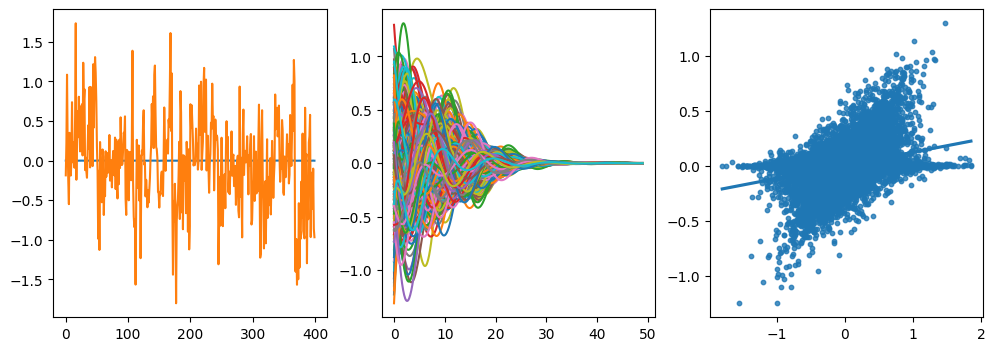

In [705]:
_, sol = solve_ode(A_opt)

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
a0.plot(sol.ys[-20].T);
a0.plot(X_middles[-2].T);
a1.plot(sol.ts, sol.ys);

x = X_middles.ravel()
y = sol.ys[middle_ts_indices + 1].ravel()
sns.regplot(x=x, y=y, ax=a2, scatter_kws=dict(s=10))
print(scipy.stats.pearsonr(x, y), scipy.stats.pearsonr(x, y)[0] ** 2)

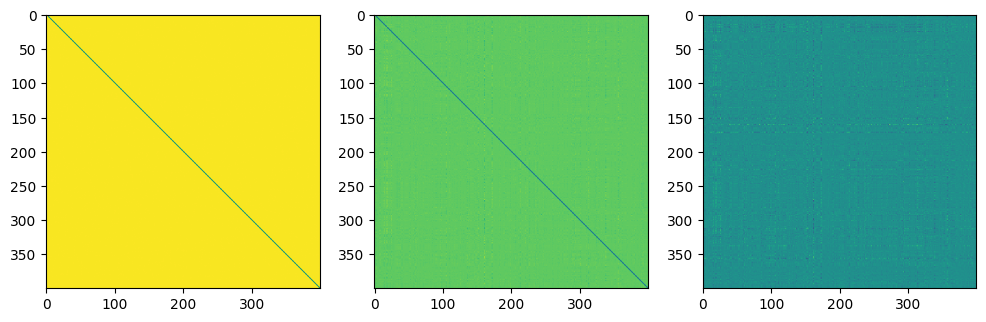

In [703]:
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 5))
a0.imshow(A_init)
a1.imshow(A_opt);
a2.imshow(A_opt - A_opt.T);

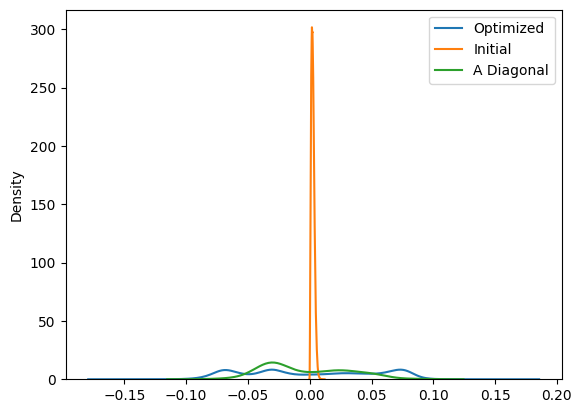

In [674]:
sns.kdeplot(A_opt.ravel(), label="Optimized")
sns.kdeplot(A_init.ravel(), label="Initial")
sns.kdeplot(A_opt[jnp.diag_indices_from(A_opt)], label="A Diagonal")
plt.legend()

## Diffrax NN Example

In [272]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax


In [290]:
from flax import linen as nn

In [304]:
class NCT_derivative(eqx.Module):

    def __init__(self, n_dim, **kwargs):
        super().__init__(**kwargs)
        self.A = nn.param('A_mat', jnn.initializers.xavier_normal(), (self.n_dim))

    def __call__(self, t, X, args):
        return self.A @ X # + B @ U

In [305]:
NCT_derivative(100)

AttributeError: module 'flax.linen' has no attribute 'param'

In [293]:
class NCT_equation(nn.Module):
    n_dim: int

    def setup(self):
        self.A = self.param('A_mat', nn.initializers.xavier_uniform(), (self.n_dim))

    def __call__(self, X):
        return self.A @ X # + B @ U

In [ ]:
class NCT_solve(eqx.Module):
    func: NCT_derivative

    def __init__(self, n_dim, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(n_dim, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [273]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)


In [278]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys


In [279]:
def _get_data(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys


In [280]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


In [281]:
def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(500, 500),
    length_strategy=(0.1, 1),
    width_size=64,
    depth=2,
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="dodgerblue")
        model_y = model(ts, ys[0, 0])
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode.png")
        plt.show()

    return ts, ys, model


Step: 0, Loss: 0.1665818989276886, Computation time: 1.7636597156524658
Step: 100, Loss: 0.01115506887435913, Computation time: 0.031762123107910156
Step: 199, Loss: 0.005499957129359245, Computation time: 0.04180550575256348
Step: 0, Loss: 0.04135756567120552, Computation time: 1.966780662536621
Step: 100, Loss: 0.018924228847026825, Computation time: 0.1886756420135498
Step: 199, Loss: 0.009158052504062653, Computation time: 0.1982429027557373


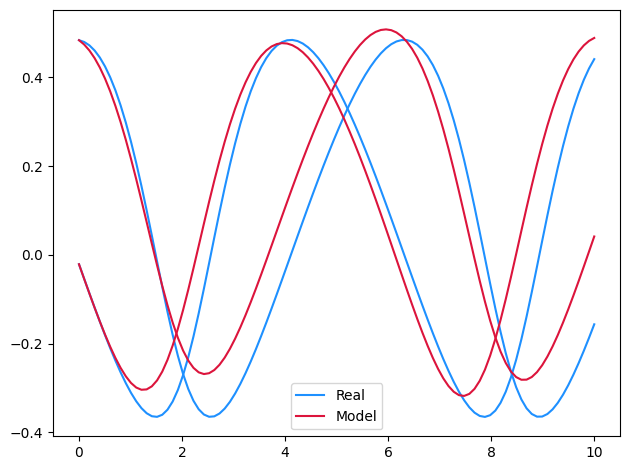

In [283]:
ts, ys, model = main(steps_strategy=(200, 200))